# Comparison with the James-Stein estimator

In [2]:
import numpy as np
import sys
sys.path.insert(1, '../../')
from SPD_SURE_pytorch import *
import matplotlib.pyplot as plt
import pandas as pd
from plotnine import *
from plotnine.data import mpg
import multiprocessing
from joblib import Parallel, delayed

In [3]:
def exp_JS(p, rng):
    N = 3 # dim of SPD
    #p = 100 # number of independent SPDs
    q = int(N*(N+1)/2)
    
    m = 20
    rho = np.linspace(-0.8, 0.8, m)

    loss_JS = np.zeros(m)
    loss_SURE = np.zeros(m)
    loss_MLE = np.zeros(m)
    
    #S = rng.uniform(0.2, 0.4, p)
    S = 0.3 * np.ones(p)
    
    for i, r in enumerate(rho):

        r_vec = rng.uniform(r-0.01, r + 0.01, p)
        M = np.array([np.array([[1, rr, rr**2],[rr, 1, rr], [rr**2, rr, 1]]) for rr in r_vec])
        #M = np.array([np.array([[1, r, r**2],[r, 1, r], [r**2, r, 1]]) for j in range(p)])
        
        X = np.array([SPD_normal(1, M[j], S[j]*np.eye(q)) for j in range(p)])
        
    
        sig2 = np.mean(S)
        # MLE
        loss_MLE[i] = loss(X, M)
    
        # James-Stein
        logX = vec(X)
        JS = vec_inv((1 - (p-2)*sig2/(np.linalg.norm(logX)**2))*logX, d = N)
        loss_JS[i] = loss(JS, M)
    
        # SURE
        _, _, M_SURE = SURE_const(X, S, verbose = False)
        loss_SURE[i] = loss(M_SURE, M)
    
    risk = pd.DataFrame(list(zip(rho, loss_JS, loss_SURE, loss_MLE)),
                    columns =['rho', 'JS', 'SURE', 'MLE'])
    return risk.values

In [6]:
seed = 2022
num_cores = -1
p = 100
k = 100

results = Parallel(n_jobs=num_cores)(delayed(exp_JS)(p, np.random.default_rng(seed + i)) \
                                                     for i in range(k))

/Users/chyang/opt/anaconda3/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6 x 4 in image.
/Users/chyang/opt/anaconda3/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: JS_comparison.pdf


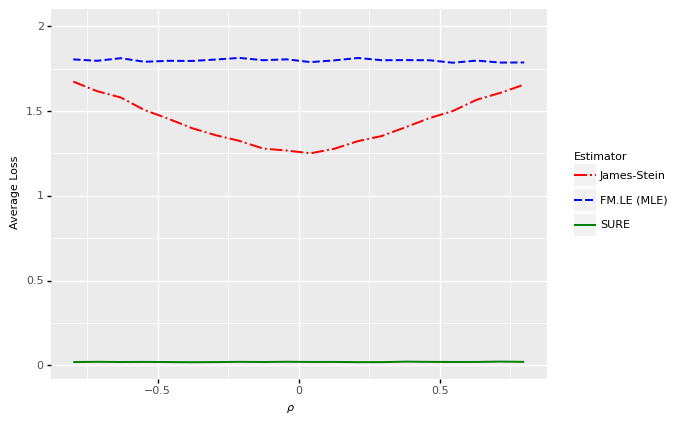

<ggplot: (8771313082088)>

In [7]:
risk = pd.DataFrame(np.mean(np.array(results), axis = 0), columns =['rho', 'JS', 'SURE', 'MLE'])

risk = pd.melt(risk, ['rho'], var_name='Estimator', value_name='risk')
fig = (ggplot(risk)
    + aes(x='rho', y='risk', color='Estimator', linetype='Estimator', ymax = 2)
    + geom_line(size = 0.8)
    + xlab(r'$\rho$')
    + ylab('Average Loss')
    + scale_color_manual(labels = ['James-Stein', 'FM.LE (MLE)', 'SURE'], 
                       values = ['red', 'blue', 'green'])
    + scale_linetype_manual(labels = ['James-Stein', 'FM.LE (MLE)', 'SURE'], 
                          values = ['dashdot','dashed','solid'])
    + theme(axis_title=element_text(size=8), 
          axis_text=element_text(size=8),
          legend_title=element_text(size=8),
          legend_text=element_text(size=8),
          strip_text=element_text(size=8))
    #+ ggtitle(r'$\mu=diag(2,0.5,0.5)$, $\Psi = I_6$, $\lambda = 10$, $\nu=15$')
    )

fig.save('JS_comparison.pdf', dpi = 320, width = 6, height = 4, units="in")
fig